In [2]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import gzip
import shutil
import glob
import rioxarray as rxr
from scipy import stats, interpolate
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt

In [3]:
# Set data directory
data_dir = "../../datasets/precipitation_chirps/chirps_tif"

## Precipitation pre-processing

### Read precipitation file

In [4]:
# Read precipitation data
precipitation_gha = xr.open_dataset('../../datasets/precipitation_chirps/precip_chirps_gha.nc')
precipitation_gha

<xarray.Dataset>
Dimensions:        (x: 591, y: 698, time: 250)
Coordinates:
    band           int64 ...
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
Data variables:
    spatial_ref    int64 ...
    precipitation  (time, y, x) float32 ...

 ## Visualise the data

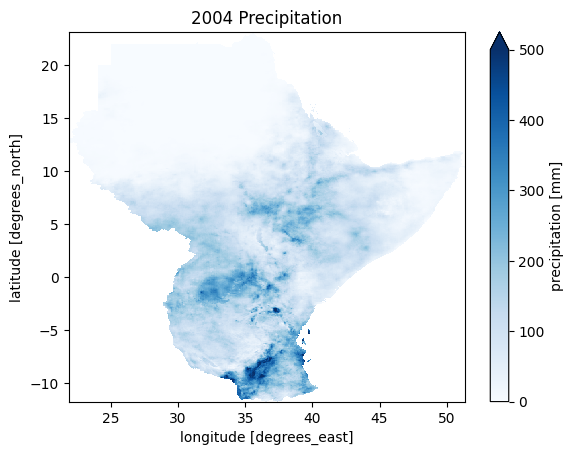

In [5]:
# Visualize sample year
sample_precip_gha = precipitation_gha['precipitation'].isel(time=0)
sample_precip_gha.plot(vmax=500, cmap="Blues")
plt.title('2004 Precipitation')
plt.show()

### Calculate baseline average

#### Process climatology

In [6]:
# Calculate monthly climatology (mean for each month over the years)
precipitation_clim = precipitation_gha.groupby("time.month").mean("time")

In [7]:
precipitation_clim

<xarray.Dataset>
Dimensions:        (x: 591, y: 698, month: 12)
Coordinates:
    band           int64 1
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * month          (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    spatial_ref    (month) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    precipitation  (month, y, x) float32 nan nan nan nan nan ... nan nan nan nan

In [8]:
# Calculate anomalies
precipitation_anomalies = precipitation_gha.groupby("time.month") - precipitation_clim

In [9]:
 precipitation_anomalies

<xarray.Dataset>
Dimensions:        (time: 250, x: 591, y: 698)
Coordinates:
    band           (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
    month          (time) int32 1 2 3 4 5 6 7 8 9 10 11 ... 1 2 3 4 5 6 7 8 9 10
Data variables:
    spatial_ref    (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    precipitation  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan

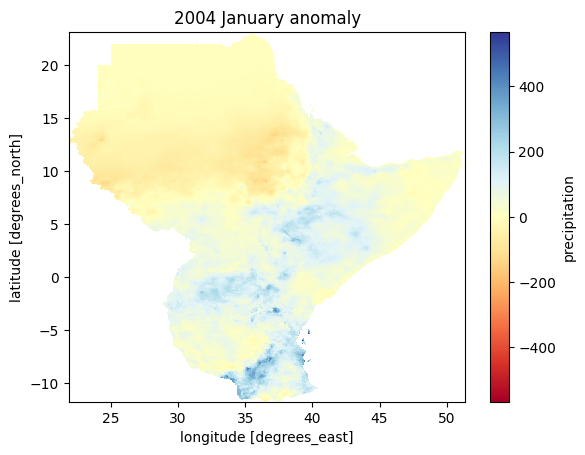

In [10]:
sample_anomaly = precipitation_anomalies['precipitation'].isel(time=0)
sample_anomaly.plot(cmap="RdYlBu")
plt.title('2004 January anomaly')
plt.show()

### Standardize the anomalies

In [11]:
# Calculate the standard deviation for each month over the years
precipitation_std = precipitation_gha.groupby("time.month").std("time")

# Calculate standardized anomalies
standardized_anomalies = precipitation_anomalies / precipitation_std

In [12]:
standardized_anomalies

<xarray.Dataset>
Dimensions:        (time: 250, x: 591, y: 698, month: 12)
Coordinates:
    band           (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
  * x              (x) float64 21.88 21.93 21.98 22.03 ... 51.28 51.33 51.38
  * y              (y) float64 23.12 23.07 23.02 22.97 ... -11.63 -11.68 -11.73
  * time           (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
  * month          (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    spatial_ref    (time, month) float64 nan nan nan nan nan ... nan nan nan nan
    precipitation  (time, y, x, month) float32 nan nan nan nan ... nan nan nan

### Stack and Remove NaNs

In [13]:
# Remove NaNs from the standardised anomalies

precipitation_sa_clean = standardized_anomalies.stack(dims=['x', 'y', 'time', 'month'])

precipitation_sa_clean = precipitation_sa_clean.precipitation[~np.isnan(precipitation_sa_clean.precipitation)]
precipitation_sa_clean

<xarray.DataArray 'precipitation' (dims: 618444000)>
array([-0.6538064 , -0.82843405, -1.0082313 , ..., -0.2828531 ,
       -0.25648725, -0.24571991], dtype=float32)
Coordinates:
    band     (dims) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * dims     (dims) object MultiIndex
  * x        (dims) float64 21.88 21.88 21.88 21.88 ... 51.38 51.38 51.38 51.38
  * y        (dims) float64 12.87 12.87 12.87 12.87 ... 10.42 10.42 10.42 10.42
  * time     (dims) datetime64[ns] 2004-01-01 2004-01-01 ... 2024-10-01
  * month    (dims) int32 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
(precipitation_sa_clean.values)

In [22]:
# Stack without year dimension - to check the distribtion accross yearly time scales
precipitation_sa_yearly = standardized_anomalies.stack(dims=['x', 'y', 'month'])
precipitation_sa_yearly


<xarray.Dataset>
Dimensions:        (time: 250, dims: 4950216)
Coordinates:
    band           (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
  * time           (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
  * dims           (dims) object MultiIndex
  * x              (dims) float64 21.88 21.88 21.88 21.88 ... 51.38 51.38 51.38
  * y              (dims) float64 23.12 23.12 23.12 ... -11.73 -11.73 -11.73
  * month          (dims) int32 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    spatial_ref    (time, dims) float64 nan nan nan nan nan ... nan nan nan nan
    precipitation  (time, dims) float32 nan nan nan nan nan ... nan nan nan nan

#### Selecting different years for marginal fitting

In [43]:
years = [2005, 2015, 2020]

selected_years = precipitation_sa_yearly.isel(time=precipitation_sa_yearly.time.dt.year.isin([years]))
selected_years

<xarray.Dataset>
Dimensions:        (time: 36, dims: 4950216)
Coordinates:
    band           (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
  * time           (time) datetime64[ns] 2005-01-01 2005-02-01 ... 2020-12-01
  * dims           (dims) object MultiIndex
  * x              (dims) float64 21.88 21.88 21.88 21.88 ... 51.38 51.38 51.38
  * y              (dims) float64 23.12 23.12 23.12 ... -11.73 -11.73 -11.73
  * month          (dims) int32 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    spatial_ref    (time, dims) float64 nan nan nan nan nan ... nan nan nan nan
    precipitation  (time, dims) float32 nan nan nan nan nan ... nan nan nan nan

In [44]:
yearly = standardized_anomalies.isel(time=standardized_anomalies.time.dt.year.isin([years])).stack(dims=['x', 'y', 'time', 'month'])
yearly

<xarray.Dataset>
Dimensions:        (dims: 178207776)
Coordinates:
    band           (dims) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
  * dims           (dims) object MultiIndex
  * x              (dims) float64 21.88 21.88 21.88 21.88 ... 51.38 51.38 51.38
  * y              (dims) float64 23.12 23.12 23.12 ... -11.73 -11.73 -11.73
  * time           (dims) datetime64[ns] 2005-01-01 2005-01-01 ... 2020-12-01
  * month          (dims) int32 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    spatial_ref    (dims) float64 nan nan nan nan nan ... nan nan nan nan nan
    precipitation  (dims) float32 nan nan nan nan nan ... nan nan nan nan nan

In [45]:
# Remove the NaNs
yearly = yearly.precipitation[~np.isnan(yearly.precipitation)]
yearly

<xarray.DataArray 'precipitation' (dims: 89055936)>
array([-0.74970263, -0.9499436 , -1.1561124 , ...,  0.16148576,
        0.14643306,  0.14028579], dtype=float32)
Coordinates:
    band     (dims) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * dims     (dims) object MultiIndex
  * x        (dims) float64 21.88 21.88 21.88 21.88 ... 51.38 51.38 51.38 51.38
  * y        (dims) float64 12.87 12.87 12.87 12.87 ... 10.42 10.42 10.42 10.42
  * time     (dims) datetime64[ns] 2005-01-01 2005-01-01 ... 2020-12-01
  * month    (dims) int32 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [56]:
precipitation_stacked_yr = selected_years.precipitation.stack(dims=['x', 'y', 'time', 'month'])
precipitation_stacked_yr

<xarray.DataArray 'precipitation' (dims: 178207776)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
    band     (dims) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * dims     (dims) object MultiIndex
  * x        (dims) float64 21.88 21.88 21.88 21.88 ... 51.38 51.38 51.38 51.38
  * y        (dims) float64 23.12 23.12 23.12 23.12 ... -11.73 -11.73 -11.73
  * time     (dims) datetime64[ns] 2005-01-01 2005-01-01 ... 2020-12-01
  * month    (dims) int32 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [50]:
max(precipitation_sa_clean.values)

126.26704

In [88]:
ymin, ymax = min(yearly.values), max(yearly.values)
ymin, ymax 

(-13.405078, 67.76188)

### Visualisation of histogram

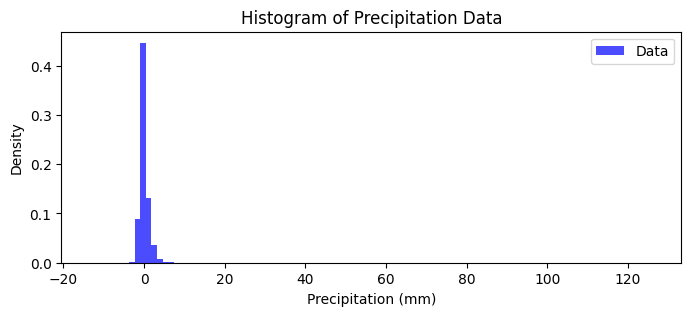

In [15]:
# Visiualise the histogram of all stacked data

plt.figure(figsize=(8, 3))
plt.hist(precipitation_sa_clean, bins=100, density=True, histtype='stepfilled', alpha=0.7, color='blue', label='Data')
# plt.xlim(-10, 10)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Density')
plt.title('Histogram of Precipitation Data')
plt.legend()
plt.show()


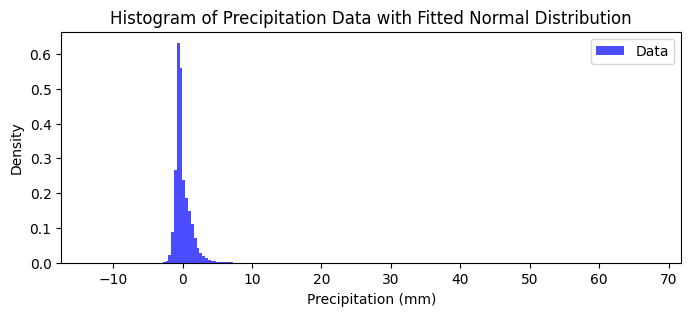

In [97]:
# Visiualise the histogram

plt.figure(figsize=(8, 3))
plt.hist(yearly, bins=200, density=True, histtype='stepfilled', alpha=0.7, color='blue', label='Data')
# plt.xlim(-10, 10)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Density')
plt.title('Histogram of Precipitation Data for selected years')
plt.legend()
plt.show()

### Cummulative distribution

In [21]:
# Sort the data for CDF calculation
# cumulative_probabilities = np.arange(1, len(precipitation_sa_clean)+1) / (len(precipitation_sa_clean)+1)
# from scipy.stats import ecdf
n = len(precipitation_sa_clean)
ecdf = np.arange(1, n+1) / n
# Alternatively, using scipy.stats to get the empirical CDF:
# ecdf = stats.ecdf(precipitation_sa_clean)

In [22]:
ecdf

array([1.61696128e-09, 3.23392255e-09, 4.85088383e-09, ...,
       9.99999997e-01, 9.99999998e-01, 1.00000000e+00])

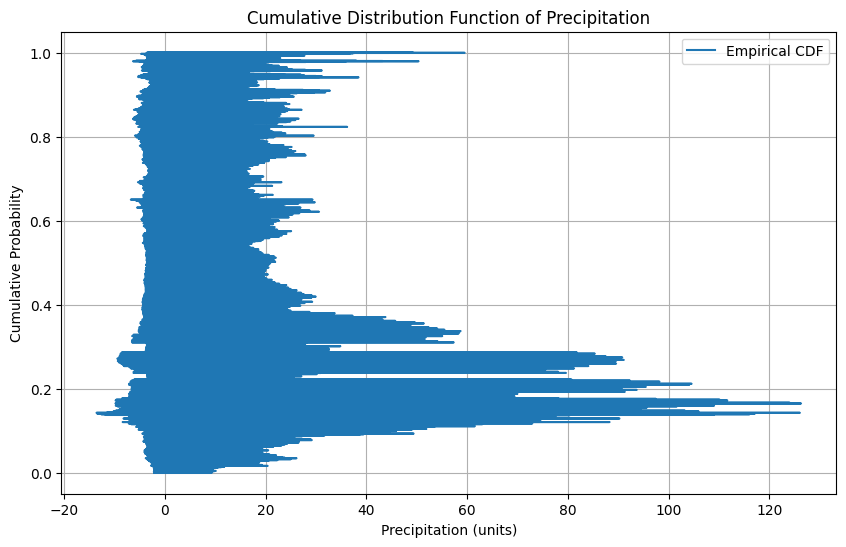

In [23]:
# Plotting the CDF

plt.figure(figsize=(10, 6))
plt.plot(precipitation_sa_clean, ecdf, label='Empirical CDF')
plt.xlabel('Precipitation (units)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function of Precipitation')
plt.legend()
plt.grid(True)
plt.show()

### Fit to marginal distribution

In [12]:
# TODO: Implement fitting marginal distribution to the data

##### Determine the normal dist params

In [92]:
norm_mean, norm_std = stats.norm.fit(precipitation_sa_clean)

In [93]:
norm_mean, norm_std

(7.610347e-11, 1.1763077)

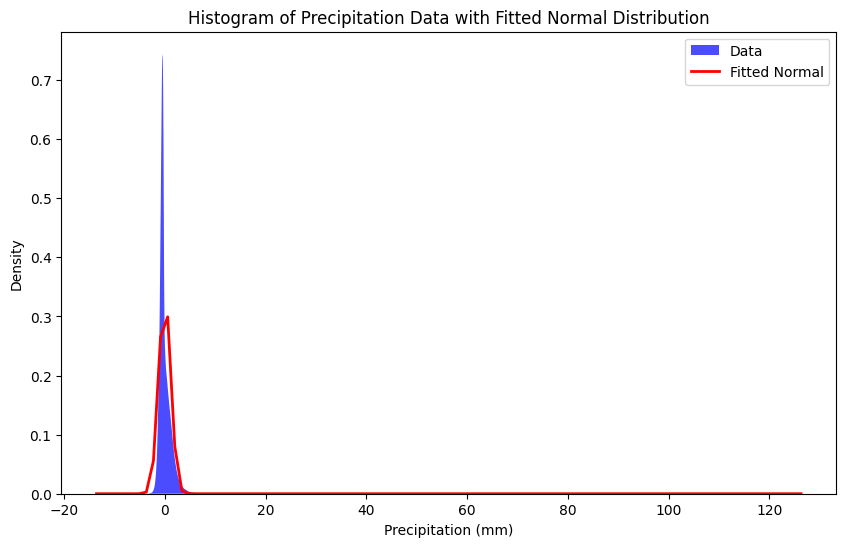

In [98]:
# Plotting the histogram and the fitted Normal distribution
plt.figure(figsize=(10, 6))
plt.hist(precipitation_sa_clean, bins='auto', density=True, histtype='stepfilled', alpha=0.7, color='blue', label='Data')

# Generate x values for plotting the fitted distribution
x = np.linspace(min(precipitation_sa_clean.values), max(precipitation_sa_clean.values), 100)
pdf_fitted = stats.norm.pdf(x, norm_mean, norm_std)
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Normal')

plt.xlabel('Precipitation (mm)')
plt.ylabel('Density')
plt.title('Histogram of Precipitation Data with Fitted Normal Distribution')
plt.legend()
plt.show()

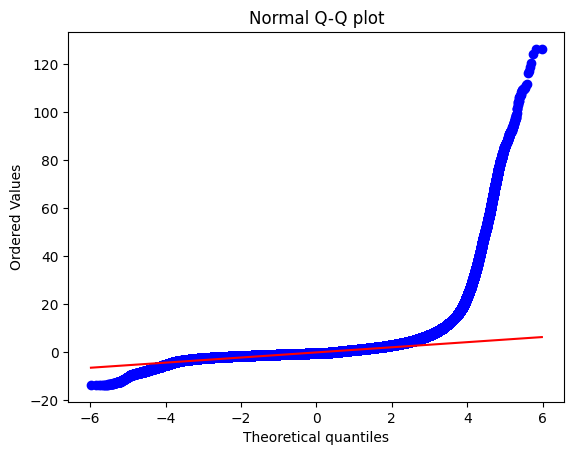

In [100]:
# Q-Q Plot
stats.probplot(precipitation_sa_clean, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [101]:
from scipy.stats import kstest

ks_stat, p_value = kstest(precipitation_sa_clean, 'norm', N=len(precipitation_sa_clean))
print(f"KS Statistic for norm: {ks_stat}, p-value: {p_value}")

KS Statistic for norm: 0.160722940171795, p-value: 0.0


In [53]:
norm_mean, norm_std = stats.norm.fit(yearly)
norm_mean, norm_std

(0.018415857, 1.1393899)

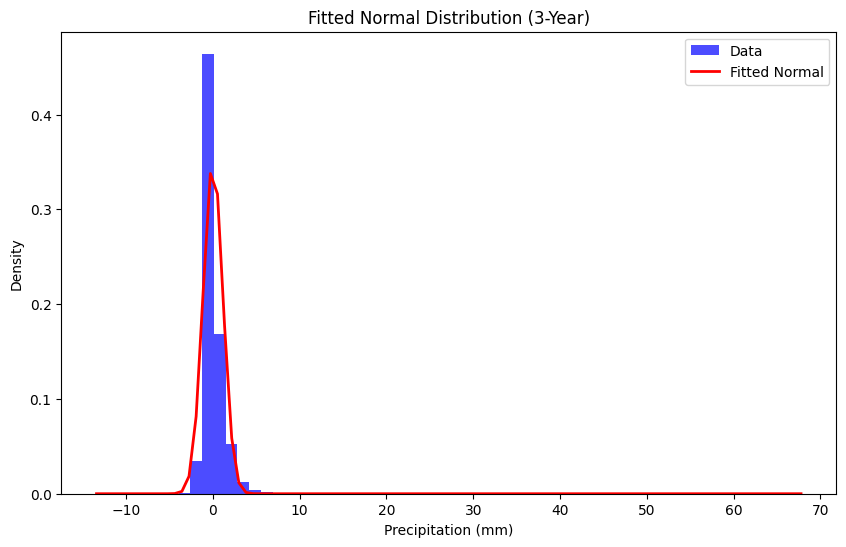

In [92]:
# Plotting the histogram and the fitted Normal distribution - selected years
plt.figure(figsize=(10, 6))
plt.hist(yearly, bins=60, density=True, histtype='stepfilled', alpha=0.7, color='blue', label='Data')

# Generate x values for plotting the fitted distribution
x = np.linspace(min(yearly.values), max(yearly.values), 100)
pdf_fitted = stats.norm.pdf(x, norm_mean, norm_std)
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Fitted Normal')

plt.xlabel('Precipitation (mm)')
plt.ylabel('Density')
plt.title('Fitted Normal Distribution (3-Year)')
plt.legend()
plt.show()

In [74]:
from scipy.stats import shapiro

stat, p_value = shapiro(yearly)
print(f"Shapiro-Wilk test statistic={stat}, p-value={p_value}")


Shapiro-Wilk test statistic=1.1005537509918213, p-value=1.0


/usr/local/lib/python3.8/dist-packages/scipy/stats/_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Gamma fitting

In [102]:
shape, loc, scale = stats.gamma.fit(precipitation_sa_clean)

In [105]:
shape, loc, scale

(85.62473679026215, -10.204204306089501, 0.11910045815550566)

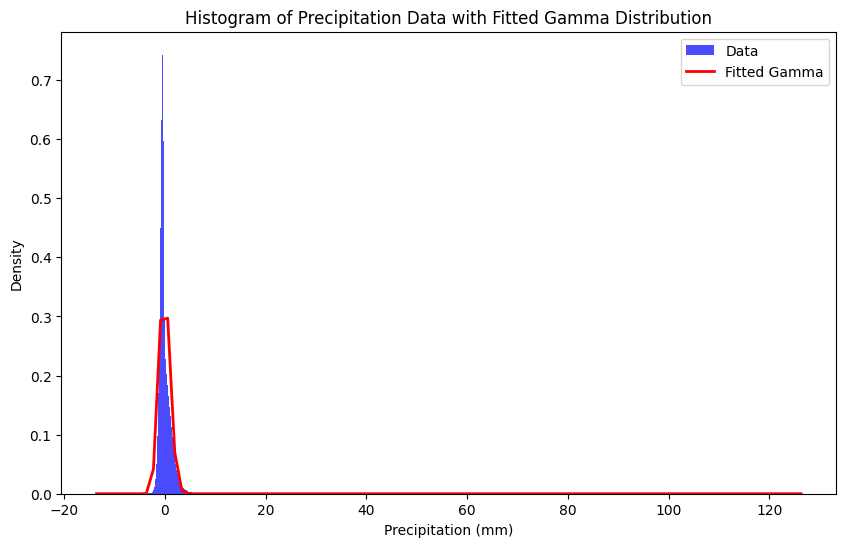

In [109]:
import matplotlib.pyplot as plt

# Create a range of x values for plotting
x = np.linspace(min(precipitation_sa_clean.values), max(precipitation_sa_clean.values), 100)

# Calculate the PDF for these values
pdf = stats.gamma.pdf(x, shape, loc=loc, scale=scale)

# Plot the histogram of the data and the fitted distribution
plt.figure(figsize=(10, 6))
plt.hist(precipitation_sa_clean, bins='auto', density=True, alpha=0.7, color='blue', label='Data')
plt.plot(x, pdf, 'r-', lw=2, label='Fitted Gamma')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Density')
plt.title('Histogram of Precipitation Data with Fitted Gamma Distribution')
plt.legend()
plt.show()

In [56]:
shape, loc, scale = stats.gamma.fit(yearly)
shape, loc, scale

(80.65142504560504, -9.718574704597678, 0.12055733892532183)

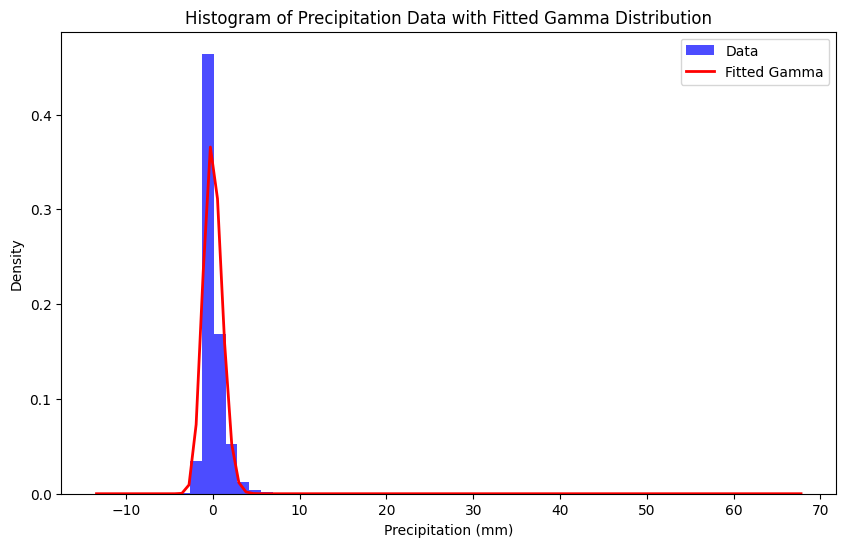

In [94]:
# Calculate the PDF for these values
pdf = stats.gamma.pdf(x, shape, loc=loc, scale=scale)

# Plot the histogram of the data and the fitted distribution
plt.figure(figsize=(10, 6))
plt.hist(yearly, bins=60, density=True, alpha=0.7, color='blue', label='Data')
plt.plot(x, pdf, 'r-', lw=2, label='Fitted Gamma')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Density')
plt.title('Histogram of Precipitation Data with Fitted Gamma Distribution')
plt.legend()
plt.show()

In [96]:
gev_params = stats.genextreme.fit(yearly)
gev_params

(-0.36211829894437353, -3.5190192287861928, 1.8323857534033303)

### TODO: Fit Marginal distribution for specific years

In [ ]:
# Select a specific time point
specific_time = 2004

# Extract spatial precipitation data
spatial_data = precipitation_anomalies.sel(time=specific_time)

# Flatten the data and plot histogram
spatial_data.plot.hist(bins=30)
plt.title(f"Marginal Distribution Over Space for {specific_time}")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Select a specific time point
specific_time = 2014

# Extract spatial precipitation data
spatial_data = precipitation_anomalies['precipitation'].sel(time=specific_time)

# Flatten the data and plot histogram
spatial_data.plot.hist(bins=30)
plt.title(f"Marginal Distribution Over Space for {specific_time}")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()


### TODO: Fit Marginal distribution for specific regions

In [ ]:
# Subset data for a bounding box (e.g., Greater Horn of Africa)
region = precipitation_anomalies['precipitation'].sel(x=slice(33, 43), y=slice(5, -5))

# Calculate mean precipitation over space or time within the region
region_mean_time = region.mean(dim=["x", "y"])
region_mean_time.plot.hist(bins=30)
plt.title("Regional Mean Precipitation Over Time")
plt.ylabel("Precipitation (mm)")
plt.show()


In [ ]:
# TODO: Transform data to uniform margins


In [ ]:
# TODO: Transform data to CDF

In [1]:
# TODO: Select Candidate Copula families

In [11]:
import numpy as np
from scipy.stats import shapiro

# Example precipitation data
precipitation_data = np.array([1.2, 0.8, 0.0, 2.3, 1.1, 0.4, 0.9, 1.5, 0.7, 1.0, 0.3, 0.04, 0.5, 0.2])

# Perform the Shapiro-Wilk test
stat, p_value = shapiro(precipitation_data)

# Print the results
print('W Statistic:', stat)
print('P-Value:', p_value)

# Interpretation
if p_value > 0.05:
    print("The data is likely normally distributed (fail to reject H0)")
else:
    print("The data is likely not normally distributed (reject H0)")


W Statistic: 0.9346606731414795
P-Value: 0.35419613122940063
The data is likely normally distributed (fail to reject H0)


In [12]:
norm_mean, norm_std = stats.norm.fit(precipitation_data)
norm_mean, norm_std

(0.7814285714285713, 0.6049068067875903)

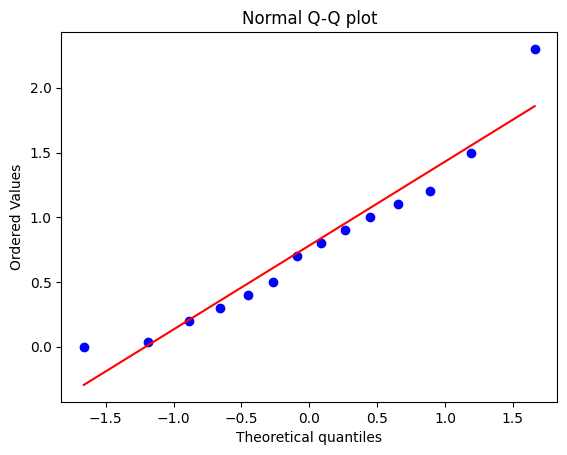

In [13]:
# Q-Q Plot
stats.probplot(precipitation_data, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

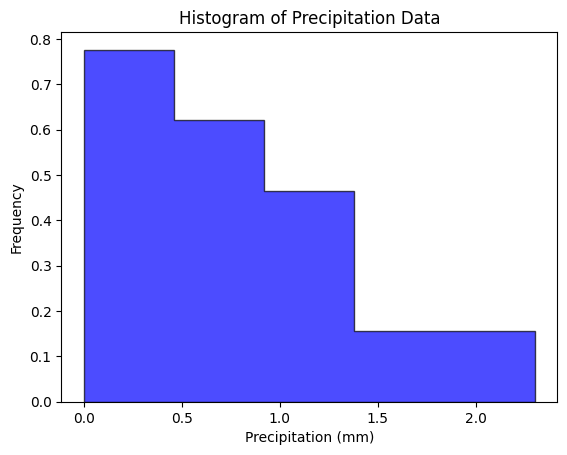

In [18]:
# Plot the histogram 
plt.hist(precipitation_data, bins=5, edgecolor='black',  density=True, histtype='stepfilled', alpha=0.7, color='blue', label='Data') 
plt.title('Histogram of Precipitation Data') 
plt.xlabel('Precipitation (mm)') 
plt.ylabel('Frequency') 
plt.show()

In [20]:
# Generate 1000 data points from an exponential distribution
non_normal_data = np.random.exponential(scale=1.0, size=1000)
# Perform the Shapiro-Wilk test
stat, p_value = shapiro(non_normal_data)

# Print the results
print('W Statistic:', stat)
print('P-Value:', p_value)

# Interpretation
if p_value > 0.05:
    print("The data is likely normally distributed (fail to reject H0)")
else:
    print("The data is likely not normally distributed (reject H0)")


W Statistic: 0.8213744163513184
P-Value: 6.412848892951922e-32
The data is likely not normally distributed (reject H0)


In [27]:
norm_mean, norm_std = stats.expon.fit(non_normal_data)
norm_mean, norm_std

(0.0009780298497330323, 1.0193898442963591)

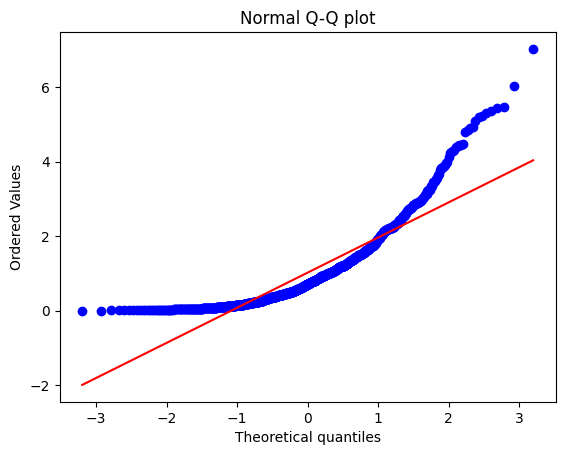

In [22]:
# Q-Q Plot
stats.probplot(non_normal_data, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

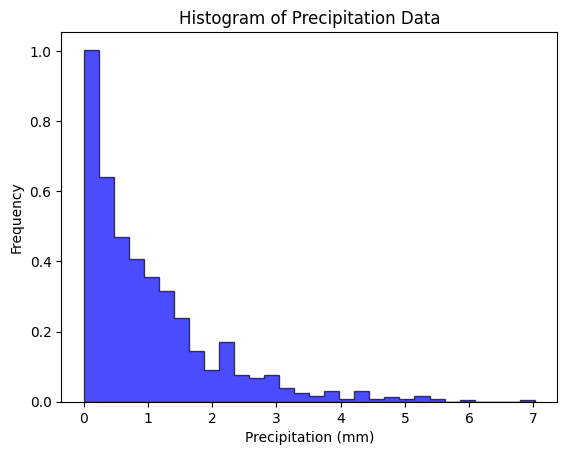

In [25]:
plt.hist(non_normal_data, bins=30, edgecolor='black',  density=True, histtype='stepfilled', alpha=0.7, color='blue', label='Data') 
plt.title('Histogram of Precipitation Data') 
plt.xlabel('Precipitation (mm)') 
plt.ylabel('Frequency') 
plt.show()